# 판별분석
- 지도학습 (이미 나뉘어진 Group들이 존재)
- 이미 나뉘어진 Group들간의 차이를 구분시켜주는 새로운 함수식을 도출함.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler #전처리
from sklearn.datasets import load_iris

In [24]:
iris = load_iris()
iris_scaled = StandardScaler().fit_transform(iris.data)

# scale이 잘되었는지 테스트
print("mean =", iris_scaled.mean(axis = 0))
print("std =",iris_scaled.std(axis = 0))

mean = [-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]
std = [1. 1. 1. 1.]


In [251]:
# n_components = 2인 이유는, 현재 label이 3개이기 때문이다.
lda = LinearDiscriminantAnalysis(n_components= 2)
# 모델 학습
lda.fit(iris_scaled, iris.target)
# 모델 적용
iris_lda = lda.transform(iris_scaled)

In [252]:
lda_cols = ["lda_1","lda_2"]
df = pd.DataFrame(data = iris_lda, columns=lda_cols)
df["target"] = iris.target

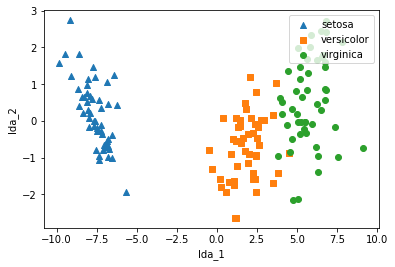

In [253]:
markers = ["^", "s", "o"]

for i, marker in enumerate(markers):
    x_data = df[df["target"] == i]["lda_1"]
    y_data = df[df["target"] == i]["lda_2"]
    plt.scatter(x_data, y_data, marker = marker, label = iris.target_names[i])

plt.legend(loc = "upper right")
plt.xlabel("lda_1")
plt.ylabel("lda_2")
plt.show()

In [53]:
lda.predict([[6.86617933e-02, -1.31979479e-01,  7.62758269e-01,
         7.90670654e-01]])

array([1])

# 기본적인 데이터분석

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split

# step1 데이터불러오기
iris = load_iris()
feature = pd.DataFrame(iris["data"])
target = pd.DataFrame(iris["target"])
data = pd.concat([feature,target], axis = 1)
data.tail()

# step2 train, test 데이터 나누기
train = data.iloc[:,:-1]
test = data.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(train, test, train_size = 0.7, random_state = 42)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(105, 4) (45, 4) (105,) (45,)


In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# step3 model
model = tree.DecisionTreeClassifier()

# step4 train
model.fit(X_train,Y_train)

# step5 test
model.score(X_test, Y_test)
#(model.predict(X_test) == Y_test).mean()

1.0

In [115]:
feature_names = data.columns[:-1].tolist()

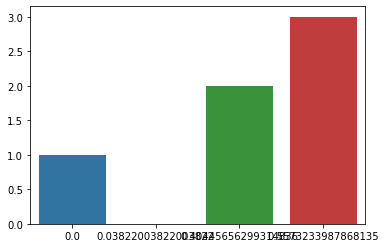

In [119]:
sns.barplot(x = model.feature_importances_, y= [0,1,2,3])

# 군집분석

https://joyfuls.tistory.com/64

In [129]:
from scipy.cluster.hierarchy import linkage, dendrogram

# 기본적인 데이터 셋팅.
iris = load_iris()
data = pd.DataFrame(iris["data"], columns= ["Sepal.Length","Sepal.Width","Petal.Length","Petal.Width"])
target = pd.DataFrame(iris["target"], columns= ["labels"])
data = pd.concat([data,target], axis = 1)



### 계층적 군집분석

In [134]:
clusters = linkage(y = data, method= "complete", metric = "euclidean")
clusters.shape


(149, 4)

### 덴드로그램 시각화: 군집수 결정

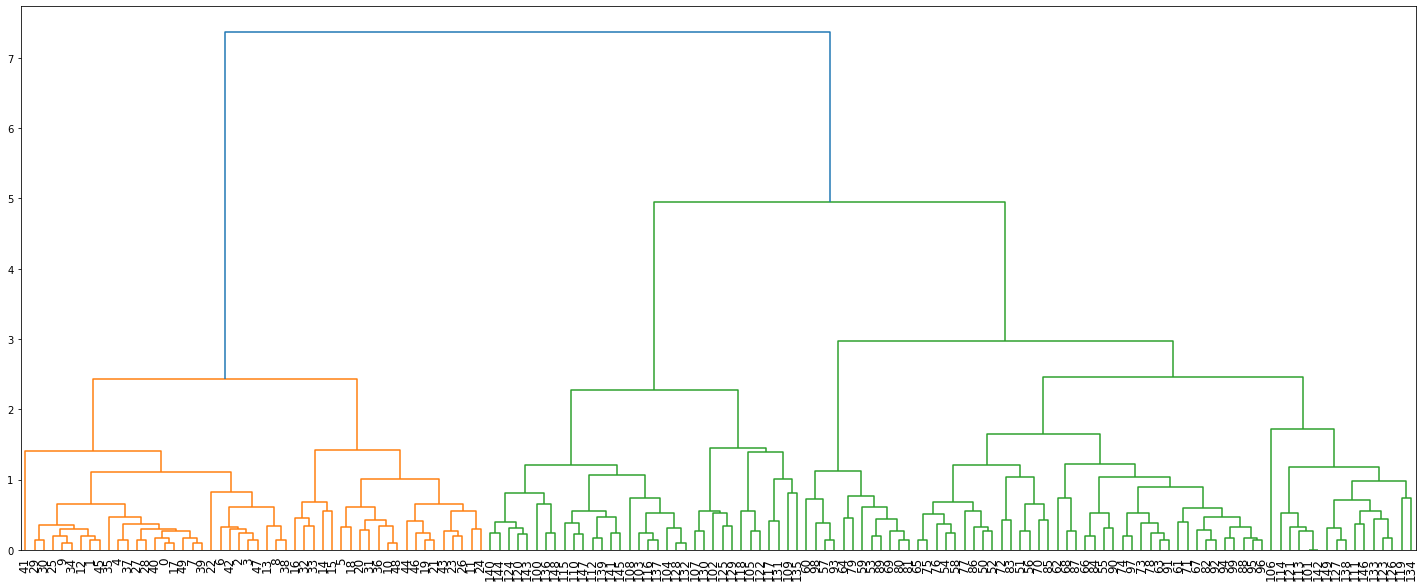

In [136]:
import matplotlib.pyplot as plt
plt.figure(figsize = (25,10))
dendrogram(clusters, leaf_rotation=90, leaf_font_size=12) # 글자각도, 글자 크기
plt.show()

### 클러스터링(군집) 결과
- 3개 정도로 자르기.

In [151]:
from scipy.cluster.hierarchy import fcluster

cut_tree = fcluster(clusters, t = 3, criterion= "distance") # t는 y축을 의미하는 것 같다.



In [156]:
df = pd.DataFrame({'pred':cut_tree, 'labels':data["labels"]})
confusion_matrix = pd.crosstab(df["pred"], df["labels"])

In [157]:
confusion_matrix

labels,0,1,2
pred,,,
1,50,0,0
2,0,0,34
3,0,50,16


### irisDF에 군집 예측치 추가

In [160]:
irisDF = data #이렇게 하면, data의 주소를 할당 받는 것임.
irisDF["cluster"] = cut_tree 

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,labels,cluster
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,1
4,5.0,3.6,1.4,0.2,0,1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,2
146,6.3,2.5,5.0,1.9,2,3
147,6.5,3.0,5.2,2.0,2,2
148,6.2,3.4,5.4,2.3,2,2


# 클러스터 산점도

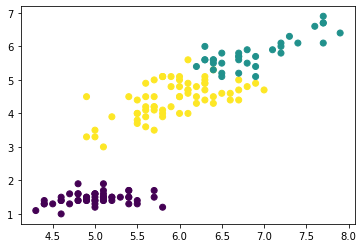

In [162]:
plt.scatter(x = irisDF["Sepal.Length"], y = irisDF["Petal.Length"], c = irisDF["cluster"])
plt.show()


In [163]:
irisDF["cluster"].value_counts()

3    66
1    50
2    34
Name: cluster, dtype: int64

In [165]:
irisDF.groupby("cluster").mean()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,labels
cluster,,,,,
1,5.006000,3.428000,1.462000,0.246000,0.000000
2,6.888235,3.100000,5.805882,2.123529,2.000000
3,5.939394,2.754545,4.442424,1.445455,1.242424


# K-means

- k개의 초기군집을 잡고, 군집의 중심을 계속해서 update

In [256]:
from sklearn.cluster import KMeans

# step1) 데이터 만들기
irisDF = irisDF[["Sepal.Length", "Petal.Length"]]

# step2) 모델 만들기
model = KMeans(n_clusters = 5, random_state= 0, algorithm= "auto")

# step3) 학습시키기 (필수적임)
model.fit(irisDF)



KMeans(n_clusters=5, random_state=0)

### 클러스터링(군집) 결과

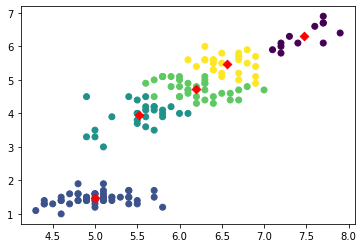

In [257]:
pred = model.predict(irisDF)
plt.scatter(x = irisDF["Sepal.Length"], y = irisDF["Petal.Length"], c = pred)

# 군집별 중앙값
center = model.cluster_centers_
plt.scatter(x = center[:,0], y = center[:,1], marker= "D", c = "r")
plt.show()


# 요인분석
- 상관계수가 높은 변수들끼리 모아서 새로운 변수를 만들자 (차원축소)
https://ysyblog.tistory.com/124

In [185]:
pip install factor-analyzer

Note: you may need to restart the kernel to use updated packages.


In [204]:
from factor_analyzer import FactorAnalyzer

df = pd.read_csv("bfi.csv", index_col = 0)
df.drop(["gender", "education", "age"], axis = 1, inplace = True)
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2436 entries, 61617 to 67560
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      2436 non-null   float64
 1   A2      2436 non-null   float64
 2   A3      2436 non-null   float64
 3   A4      2436 non-null   float64
 4   A5      2436 non-null   float64
 5   C1      2436 non-null   float64
 6   C2      2436 non-null   float64
 7   C3      2436 non-null   float64
 8   C4      2436 non-null   float64
 9   C5      2436 non-null   float64
 10  E1      2436 non-null   float64
 11  E2      2436 non-null   float64
 12  E3      2436 non-null   float64
 13  E4      2436 non-null   float64
 14  E5      2436 non-null   float64
 15  N1      2436 non-null   float64
 16  N2      2436 non-null   float64
 17  N3      2436 non-null   float64
 18  N4      2436 non-null   float64
 19  N5      2436 non-null   float64
 20  O1      2436 non-null   float64
 21  O2      2436 non-null   int64  


# 요인성 평가
### 1) Bartlett의 테스트
상관관계 행렬상의 모든 상관관계 값들이 전반적인 유의성을 나타냄


In [206]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value, p_value = calculate_bartlett_sphericity(df)

print(chi_square_value, p_value) # p_value가 0.0이므로, 귀무가설을 기각하고 대립가설을 채택 -> 유의하다.


18170.96635086924 0.0


### 2) KMO 검정
전체 상관관계행렬이 요인분석에 적합한지를 나타내는 지표
0.5보다는 커야함.

In [207]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df)
kmo_model

0.848539722194922

### 요인 수 선택

In [208]:
fa = FactorAnalyzer(n_factors=25, rotation=None)
fa.fit(df)
# Eigen value 체크
ev, v = fa.get_eigenvalues()
ev

array([5.13431118, 2.75188667, 2.14270195, 1.85232761, 1.54816285,
       1.07358247, 0.83953893, 0.79920618, 0.71898919, 0.68808879,
       0.67637336, 0.65179984, 0.62325295, 0.59656284, 0.56309083,
       0.54330533, 0.51451752, 0.49450315, 0.48263952, 0.448921  ,
       0.42336611, 0.40067145, 0.38780448, 0.38185679, 0.26253902])

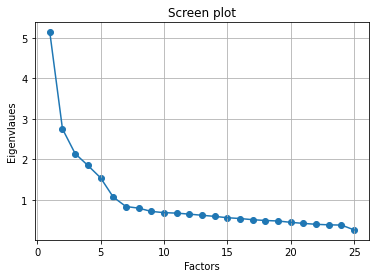

In [217]:
plt.scatter(range(1,df.shape[1]+1), ev)
plt.plot(range(1,df.shape[1]+1), ev)
plt.title("Screen plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvlaues")
plt.grid()
plt.show()


# 탐색적 요인분석 실시
- Screen plot 분석결과, 6개 이후부터 기울기가 둔감하게 감소함을 알 수 있다.

In [221]:
# 모델 만들기
fa = FactorAnalyzer(n_factors=6, rotation="varimax")

# 모델 적용하기
fa.fit(df)

# 결과
efa_result = pd.DataFrame(fa.loadings_, index = df.columns)
efa_result



,0,1,2,3,4,5
A1,0.095220,0.040783,0.048734,-0.530987,-0.113057,0.161216
A2,0.033131,0.235538,0.133714,0.661141,0.063734,-0.006244
A3,-0.009621,0.343008,0.121353,0.605933,0.033990,0.160106
A4,-0.081518,0.219717,0.235140,0.404594,-0.125338,0.086356
A5,-0.149616,0.414458,0.106382,0.469698,0.030977,0.236519
C1,-0.004358,0.077248,0.554582,0.007511,0.190124,0.095035
C2,0.068330,0.038370,0.674545,0.057055,0.087593,0.152775
C3,-0.039994,0.031867,0.551164,0.101282,-0.011338,0.008996
C4,0.216283,-0.066241,-0.638475,-0.102617,-0.143846,0.318359
C5,0.284187,-0.180812,-0.544838,-0.059955,0.025837,0.132423


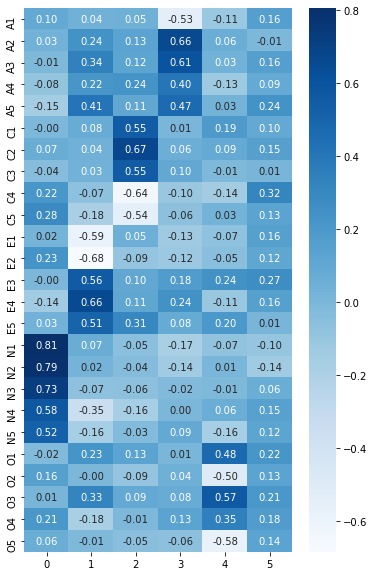

In [224]:
plt.figure(figsize = (6,10))
sns.heatmap(efa_result, cmap = "Blues", annot = True, fmt ='.2f')

# 해석
- 요인0는 N1 ~ N5 높은 요인 적재량을 가진다.
- 요인1,2,3,4도 마찬지로 각각의 높은 요인 적재량을 가진다고 할 수 있다.
- 요인5에는 변수에 대해 높은 요인 적재량이 없다고 해석할 수 있다.
따라서, 위의 5가지 요소만 활용한다.

# 5개 요인으로 분석

In [225]:
fa = FactorAnalyzer(n_factors= 5, rotation="varimax")
fa.fit(df)


FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [231]:
df1 = pd.DataFrame(fa.get_factor_variance(), index = ["SS Loadings", "Proportion Var","Cumulative Var"])
df1


,0,1,2,3,4
SS Loadings,2.709633,2.473090,2.041106,1.844498,1.522153
Proportion Var,0.108385,0.098924,0.081644,0.073780,0.060886
Cumulative Var,0.108385,0.207309,0.288953,0.362733,0.423619


# 신뢰도 측정
- 구해진 요인들이 신뢰할만한지 측정한다.
- 이때, 크론바흐 알파계수를 확인한다.

In [232]:
def CronbachAlpha(itemscores):
    itemscores = numpy.asarray(itemscores)
    itemvars = itemscores.var(axis=1, ddof=1)
    tscores = itemscores.sum(axis=0)
    nitems = len(itemscores)

    return nitems / (nitems-1.) * (1 - itemvars.sum() / tscores.var(ddof=1))

In [239]:
factors = ["A","C","E","N","O"]
factors_items_dict = {}

for factor in factors:
    print(factor)
    factors_items_dict[factor] = [x for x in df.columns if x[0] == factor]

factors_items_dict
    
    
    

A
C
E
N
O


{'A': ['A1', 'A2', 'A3', 'A4', 'A5'],
 'C': ['C1', 'C2', 'C3', 'C4', 'C5'],
 'E': ['E1', 'E2', 'E3', 'E4', 'E5'],
 'N': ['N1', 'N2', 'N3', 'N4', 'N5'],
 'O': ['O1', 'O2', 'O3', 'O4', 'O5']}

In [250]:
import numpy

for key,value in factors_items_dict.items():
    print(key)
    print(df[value].columns)
    print(CronbachAlpha(df[value]))
    print()

A
Index(['A1', 'A2', 'A3', 'A4', 'A5'], dtype='object')
0.999382578588122

C
Index(['C1', 'C2', 'C3', 'C4', 'C5'], dtype='object')
0.9988745493847423

E
Index(['E1', 'E2', 'E3', 'E4', 'E5'], dtype='object')
0.997862678056552

N
Index(['N1', 'N2', 'N3', 'N4', 'N5'], dtype='object')
0.9899557559197251

O
Index(['O1', 'O2', 'O3', 'O4', 'O5'], dtype='object')
0.999507054933464

